In [13]:
from pathlib import Path
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from evolution.candidate import Candidate
from evolution.evaluation.evaluator import Evaluator

In [14]:
results_dir = Path("results/context/single")
config = json.load(open(results_dir / "config.json"))
gens = len(list(results_dir.glob("[0-9]*.csv")))-1
context = config["context"]
actions = config["actions"]
outcomes = config["outcomes"]
n_elites = config["evolution_params"]["n_elites"]
print(gens, outcomes)

6 {'CO2 Equivalent Net Emissions': True, 'Total cost of energy': True, 'Cost of energy next 10 years': True}


In [15]:
model_params = config["model_params"]
input_specs = pd.read_json("inputSpecs.jsonl", lines=True)
model_params["in_size"] = len(context) if len(context) > 0 else len(input_specs) - len(actions)
model_params["out_size"] = len(actions)

evaluator = Evaluator("experiments/temp", context, actions, outcomes)

make: `enroads' is up to date.


In [16]:
baseline_actions = {}
baseline_df = evaluator.evaluate_actions(baseline_actions)
outcome_keys = list(outcomes.keys())
enroads_outcomes = [key for key in outcome_keys if key not in ["Cost of energy next 10 years"]]
print(baseline_df[enroads_outcomes].iloc[-1])

CO2 Equivalent Net Emissions    71.7844
Total cost of energy            14.0347
Name: 110, dtype: float64


In [17]:
final_gen_df = pd.read_csv(results_dir / f"{gens}.csv")
final_pareto = final_gen_df[final_gen_df["rank"] == 1]
final_pareto.loc[:,outcome_keys] = final_pareto.loc[:,outcome_keys].replace([float("inf"), -float("inf")], np.nan)
final_pareto = final_pareto.dropna(subset=outcome_keys)
final_pareto

,cand_id,parents,rank,distance,CO2 Equivalent Net Emissions,Total cost of energy,Cost of energy next 10 years
0,5_75,"['4_72', '0_75']",1,inf,47.7461,14.5810,9.302281
1,2_7,"['1_63', '0_68']",1,inf,46.7259,13.2135,9.950172
2,0_52,[],1,inf,21.2043,19.4116,9.984028
3,6_8,"['5_35', '4_72']",1,0.0,50.6727,14.2445,9.309485
4,5_38,"['4_72', '0_75']",1,0.0,50.0654,14.4802,9.321247
5,5_35,"['0_75', '0_75']",1,0.0,49.3366,14.3840,9.322948
6,4_72,"['0_75', '0_75']",1,0.0,50.2717,14.3564,9.328422
7,6_53,"['5_28', '5_33']",1,0.0,36.1488,16.8653,9.342253
8,5_60,"['2_11', '3_51']",1,0.0,44.6559,15.0897,9.391772
9,5_78,"['3_0', '3_28']",1,0.0,32.5910,22.8949,9.462645


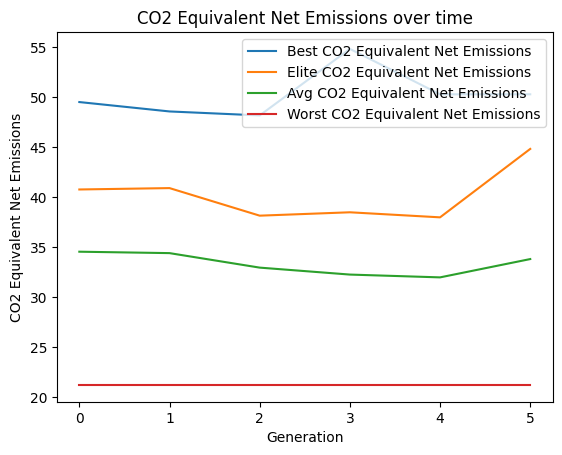

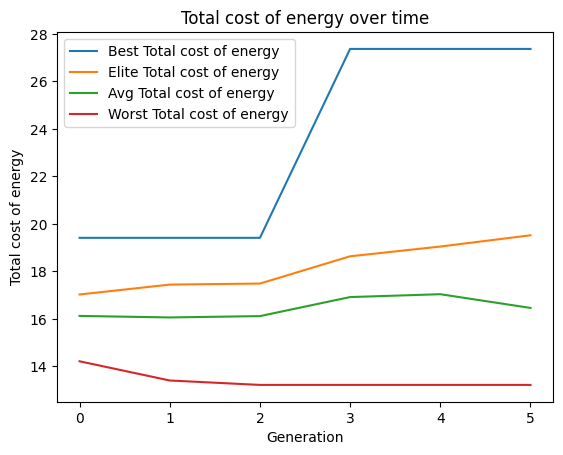

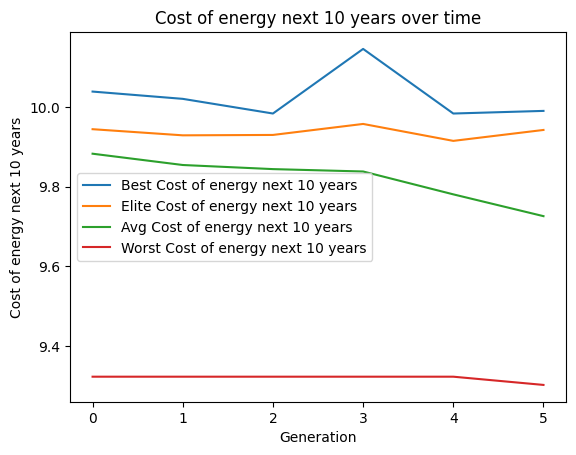

In [18]:
def plot_objective_over_time(outcome):
    best = []
    worst = []
    avg = []
    elite = []
    for gen in range(gens):
        gen_df = pd.read_csv(results_dir / f"{gen}.csv")
        pareto = gen_df[gen_df["rank"] == 1]
        scores = pareto[(pareto[outcome] != float("inf")) & (pareto[outcome] != -float("inf"))][outcome]
        best.append(scores.max())
        worst.append(scores.min())
        avg.append(scores.mean())
        elite.append(scores.nlargest(n_elites).mean())
    
    # plt.plot(range(gens), [baseline_df[outcome].iloc[-1] for _ in range(gens)], label=f"Baseline {outcome}", color="black")

    plt.plot(range(gens), best, label=f"Best {outcome}")
    plt.plot(range(gens), elite, label=f"Elite {outcome}")
    plt.plot(range(gens), avg, label=f"Avg {outcome}")
    plt.plot(range(gens), worst, label=f"Worst {outcome}")
    plt.legend()
    plt.xlabel("Generation")
    plt.ylabel(outcome)
    plt.title(f"{outcome} over time")
    plt.show()

for outcome in outcomes:
    plot_objective_over_time(outcome)

/var/folders/4c/sd5grc691sx_dp1xqn1s9dyc0000gq/T/ipykernel_27783/1830829443.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


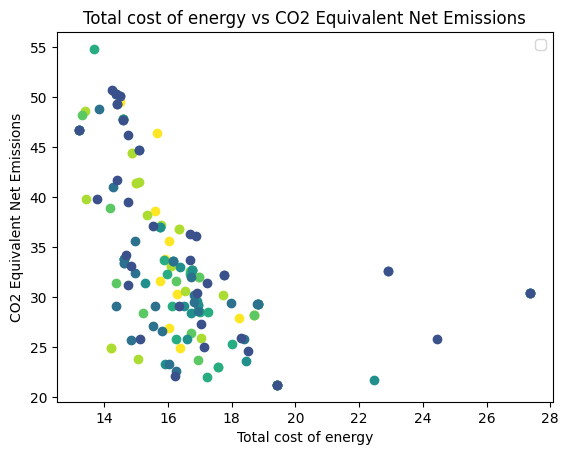

/var/folders/4c/sd5grc691sx_dp1xqn1s9dyc0000gq/T/ipykernel_27783/1830829443.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


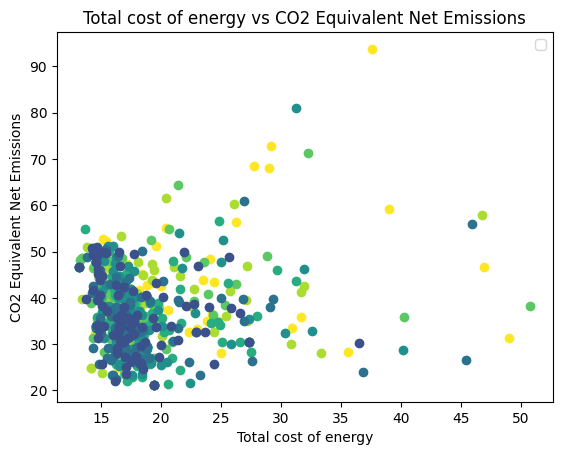

In [19]:
def plot_two_objective(outcome1, outcome2, gens, pareto=True):
    if len(gens) == 1:
        colors = ["C0"]
    else:
        colors = plt.cm.viridis_r([i / (len(gens)+1) for i in range(len(gens)+1)])
    for gen in gens:
        gen_df = pd.read_csv(results_dir / f"{gen}.csv")
        gen_df = gen_df[gen_df["rank"] == 1] if pareto else gen_df
        gen_df = gen_df[(gen_df[outcome1] != float("inf")) & (gen_df[outcome1] != -float("inf"))]
        plt.scatter(gen_df[outcome1], gen_df[outcome2], color=colors[gens.index(gen)])

    # plt.scatter(baseline_df[outcome1].iloc[-1], baseline_df[outcome2].iloc[-1], color="black", label="Baseline")
    plt.legend()
    plt.title(f"{outcome1} vs {outcome2}")
    plt.ylabel(outcome2)
    plt.xlabel(outcome1)
    plt.show()

plot_two_objective(outcome_keys[1], outcome_keys[0], range(gens+1))
plot_two_objective(outcome_keys[1], outcome_keys[0], range(gens+1), pareto=False)
# plot_two_objective(outcome_keys[2], outcome_keys[3], range(gens+1))
# plot_two_objective(outcomes[1], outcomes[0], [1, 25, 50, 100])
# plot_two_objective(outcomes[2], outcomes[1], range(gens+1))
# plot_two_objective(outcomes[2], outcomes[0], range(gens+1))

In [20]:
def get_candidate_actions(candidate: Candidate, torch_context):
    cand_actions = dict(zip(actions, candidate.prescribe(torch_context)))
    return cand_actions

def get_candidate_from_id(results_dir: Path, cand_id: str):
    cand_path = results_dir / cand_id.split("_")[0] / f"{cand_id}.pt"
    return Candidate.from_seed(cand_path, model_params, actions, outcomes)

In [21]:
best_cand_ids = []
for outcome in outcomes:
    best_cand_ids.append(final_pareto.sort_values(outcome, ascending=False).iloc[0]["cand_id"])
    print(final_pareto.sort_values(outcome, ascending=False).iloc[0][outcome_keys])
    print()
best_cand_ids = list(set(best_cand_ids))
best_cand_ids

CO2 Equivalent Net Emissions     50.6727
Total cost of energy             14.2445
Cost of energy next 10 years    9.309485
Name: 3, dtype: object

CO2 Equivalent Net Emissions     30.4414
Total cost of energy             27.3715
Cost of energy next 10 years    9.603771
Name: 13, dtype: object

CO2 Equivalent Net Emissions       22.061
Total cost of energy              16.2075
Cost of energy next 10 years    10.393647
Name: 31, dtype: object



['6_68', '6_8', '3_0']

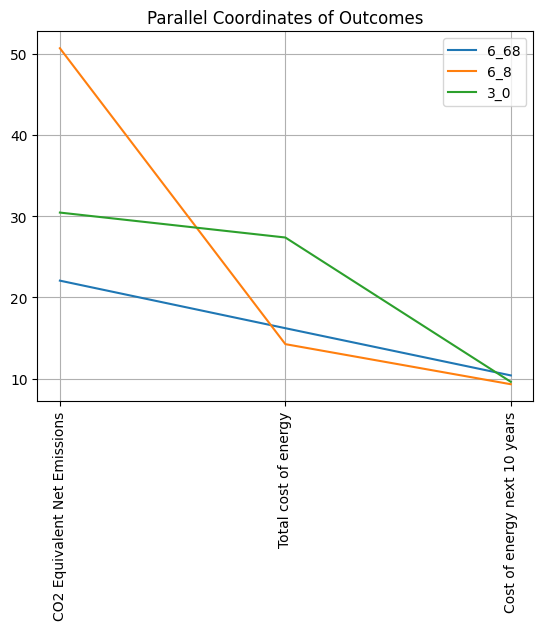

In [22]:
def plot_parallel_coordinates(cand_ids):
    coords = []
    for cand_id in cand_ids:
        gen = int(cand_id.split("_")[0])
        gen_df = pd.read_csv(results_dir / f"{gen}.csv")
        row = gen_df[gen_df["cand_id"] == cand_id].iloc[0]
        cand_coords = [row[outcome] for outcome in outcomes]
        coords.append(cand_coords)
    
    for cand_coords, cand_id in zip(coords, cand_ids):
        plt.plot(range(len(outcomes)), cand_coords, label=cand_id)
    
    plt.title("Parallel Coordinates of Outcomes")
    plt.xticks(range(len(outcomes)), outcomes.keys(), rotation=90)
    plt.grid()
    plt.legend()
    plt.show()

plot_parallel_coordinates(best_cand_ids)

In [23]:
def plot_readable_actions(cand_id):
    cand = get_candidate_from_id(results_dir, cand_id)
    cand_actions = get_candidate_actions(cand, evaluator.torch_context[0])
    input_specs = pd.read_json("inputSpecs.jsonl", lines=True)
    i = 0
    fig, ax = plt.subplots(figsize=(5, 10))
    for act, val in cand_actions.items():
        row = input_specs[input_specs["varId"] == act]
        if row["kind"].iloc[0] == "slider":
            min_val = input_specs[input_specs["varId"] == act]["minValue"].iloc[0]
            max_val = input_specs[input_specs["varId"] == act]["maxValue"].iloc[0]
            assert val >= min_val and val <= max_val
            normalized_y = (val - min_val) / (max_val - min_val)
            # ax.scatter([i, i, i], [0, normalized_y, 1])
            ax.scatter([normalized_y], [i])
            ax.annotate(f"{val:.2f}", (normalized_y, i))
        else:
            assert val == 0 or val == 1
            ax.scatter([val], [i])
            ax.annotate("on" if val == 1 else "off", (val, i))
        
        i += 1

    ax.set_yticks(range(len(cand_actions)))
    labels = [input_specs[input_specs["varId"] == act]["varName"].iloc[0] for act in cand_actions.keys()]
    ax.set_yticklabels(labels)
    plt.title(f"Actions for Candidate {cand_id}")
    plt.ylabel("Action")
    plt.xlabel("Minmax Normalized Value")
    plt.grid(axis="y")
    plt.show()

def visualize_action_differences(cand_id1, cand_id2):
    cand1 = get_candidate_from_id(results_dir, cand_id1)
    cand2 = get_candidate_from_id(results_dir, cand_id2)
    cand1_actions = get_candidate_actions(cand1, evaluator.torch_context[0])
    cand2_actions = get_candidate_actions(cand2, evaluator.torch_context[0])
    input_specs = pd.read_json("inputSpecs.jsonl", lines=True)

    fig, ax = plt.subplots(figsize=(5, 10))
    annotations = []
    labels = []
    y_positions = []
    for i, act in enumerate(actions):
        cand1_val = cand1_actions[act]
        cand2_val = cand2_actions[act]
        row = input_specs[input_specs["varId"] == act]
        y_positions.append(i)
        labels.append(input_specs[input_specs["varId"] == act]["varName"].iloc[0])
        if row["kind"].iloc[0] == "slider":
            min_val = input_specs[input_specs["varId"] == act]["minValue"].iloc[0]
            max_val = input_specs[input_specs["varId"] == act]["maxValue"].iloc[0]
            normalized1 = (cand1_val - min_val) / (max_val - min_val)
            normalized2 = (cand2_val - min_val) / (max_val - min_val)
            ax.scatter([normalized1 - normalized2], [i])
            # ax.annotate(f"{cand1_val:.2f} - {cand2_val:.2f}", (normalized1 - normalized2, i))
            annotations.append(f"{cand1_val:.2f} - {cand2_val:.2f}")
        else:
            assert cand1_val == 0 or cand1_val == 1
            assert cand2_val == 0 or cand2_val == 1
            ax.scatter([cand1_val - cand2_val], [i])
            # ax.annotate(f"{cand1_val} - {cand2_val}", (cand1_val - cand2_val, i))
            annotations.append(f"{cand1_val} - {cand2_val}")

    assert len(annotations) == len(labels)
    ax.set_yticks(range(len(labels)))
    ax.set_yticklabels(labels)
    plt.axvline(0, color="black")
    plt.title(f"{cand_id1} vs. {cand_id2}")
    ax.set_xticks(range(-1, 1))
    plt.ylabel("Action")
    plt.xlabel("Minmax Normalized Value")
    plt.grid(axis="y")
    # plt.tight_layout()
    plt.show()

# for best_cand_id in best_cand_ids:
#     plot_readable_actions(best_cand_id)
# visualize_action_differences(best_cand_ids[0], best_cand_ids[1])
# visualize_action_differences(best_cand_ids[1], best_cand_ids[2])

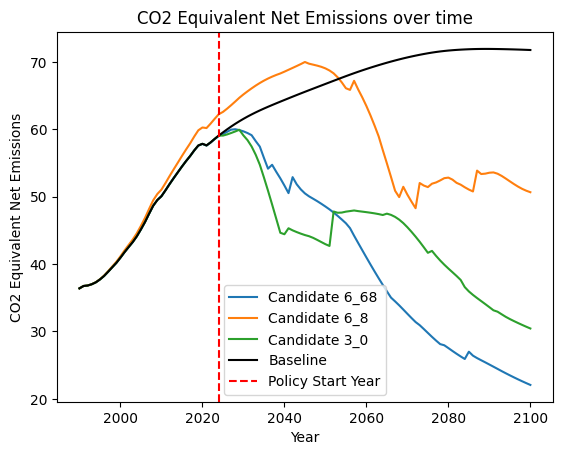

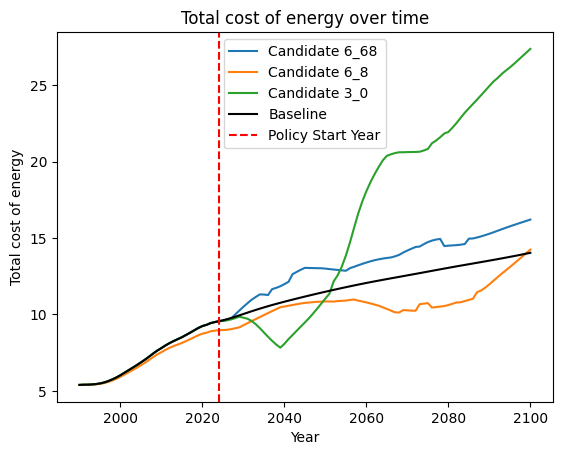

In [24]:
def plot_outcome_over_time(outcome, cand_ids):
    for cand_id in cand_ids:
        cand = get_candidate_from_id(results_dir, cand_id)
        cand_outcomes = evaluator.evaluate_candidate(cand)
        plt.plot(range(1990, 2101), cand_outcomes[outcome], label=f"Candidate {cand_id}")
    plt.plot(range(1990, 2101), baseline_df[outcome], color="black", label="Baseline")
    plt.axvline(x=2024, color="red", linestyle="--", label="Policy Start Year")
    plt.legend()
    plt.title(f"{outcome} over time")
    plt.xlabel("Year")
    plt.ylabel(outcome)
    plt.show()

cand_ids = best_cand_ids
for outcome in enroads_outcomes:
    plot_outcome_over_time(outcome, cand_ids)